In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import CSVLogger

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

### 데이터 불러오기

In [2]:
## train, valid, test set 불러오기
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    with_info=True,
)

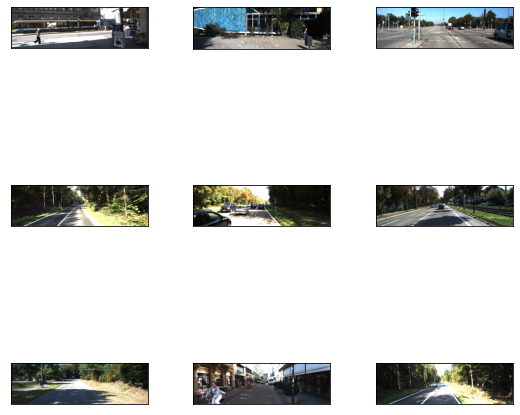

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### 데이터 확인하기

In [5]:
train_sample = ds_train.take(2)
valid_sample = ds_valid.take(1)
test_sample = ds_test.take(1)

In [6]:
def check_sample(sample, ds_type):
    for i, ex in enumerate(sample):
        print(f"## {ds_type} example {i+1}")
        print(list(ex.keys()))
        img = ex["image"]
        filename = ex["image/file_name"].numpy().decode("utf-8")
        objects = ex["objects"]

        print("-----     objects     -----")
        print(objects)

        img = Image.fromarray(img.numpy())
        plt.figure(figsize=(12,6))
        plt.imshow(img)
        plt.show()
    return img, objects

## train example 1
['image', 'image/file_name', 'objects']
-----     objects     -----
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.86, 1.78, 1.66], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.15      , 0.2015781 , 0.47650668, 0.35160226],
       [0.30914667, 0.3097182 , 0.5501867 , 0.39968598],
       [0.43210667, 0.4125282 , 0.52104   , 0.44924316]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.39, 1.48, 3.76],
       [1.81, 1.66, 4.05],
       [1.46, 1.75, 4.23]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-3.74,  1.78, 10.66],
       [-3.8 ,  1.76, 16.65],
       [-3.51,  1.79, 34.16]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.53, 1.56, 1.56], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([

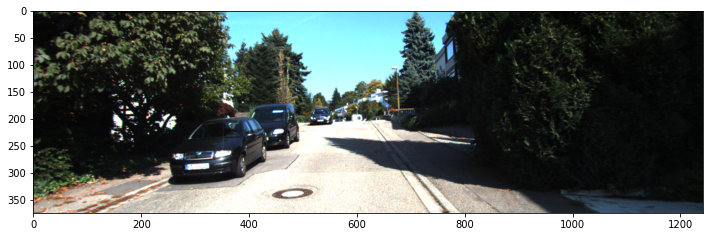

## train example 2
['image', 'image/file_name', 'objects']
-----     objects     -----
{'alpha': <tf.Tensor: shape=(6,), dtype=float32, numpy=array([-1.69, -1.82, -2.64, -1.79, -1.97, -2.83], dtype=float32)>, 'bbox': <tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[0.42352   , 0.52508855, 0.52128   , 0.5631079 ],
       [0.30752   , 0.57627213, 0.52346665, 0.675781  ],
       [0.00266667, 0.92995167, 0.55341333, 0.99919486],
       [0.46288   , 0.5683655 , 0.53248   , 0.6021095 ],
       [0.32541335, 0.6411192 , 0.79933333, 0.8378341 ],
       [0.42898667, 0.7945008 , 0.5217867 , 0.87263286]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1.38, 1.49, 3.32],
       [1.5 , 1.62, 3.89],
       [1.69, 1.58, 3.95],
       [1.44, 1.56, 3.96],
       [3.55, 2.56, 7.97],
       [1.48, 1.36, 3.51]], dtype=float32)>, 'location': <tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[ 2.56,  1.66, 29.1 ],
       [ 3.4 ,  1.64, 15.51],
       [ 3.67

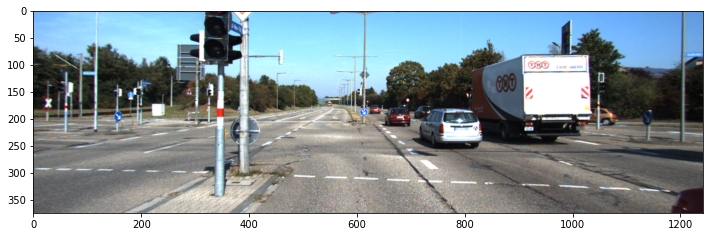

## valid example 1
['image', 'image/file_name', 'objects']
-----     objects     -----
{'alpha': <tf.Tensor: shape=(11,), dtype=float32, numpy=
array([ 2.07, -2.03,  1.85, -1.84, -1.59, -2.6 , -1.38, -1.61, -0.33,
       -1.45, -1.32], dtype=float32)>, 'bbox': <tf.Tensor: shape=(11, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.48026666, 0.30796295],
       [0.00266667, 0.6721256 , 0.5098133 , 0.99919486],
       [0.19490667, 0.2170773 , 0.61354667, 0.37630436],
       [0.18741333, 0.59020126, 0.51482666, 0.7577214 ],
       [0.34693334, 0.5848148 , 0.52765334, 0.6500483 ],
       [0.364     , 0.04380837, 0.63512   , 0.2738889 ],
       [0.39933333, 0.59772944, 0.5665067 , 0.66860706],
       [0.46925333, 0.49103865, 0.5656267 , 0.5186151 ],
       [0.46621335, 0.6382367 , 0.6148267 , 0.75670695],
       [0.45906666, 0.39202094, 0.5313067 , 0.423438  ],
       [0.45669332, 0.34706923, 0.55552   , 0.38597423]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(11, 3), dtyp

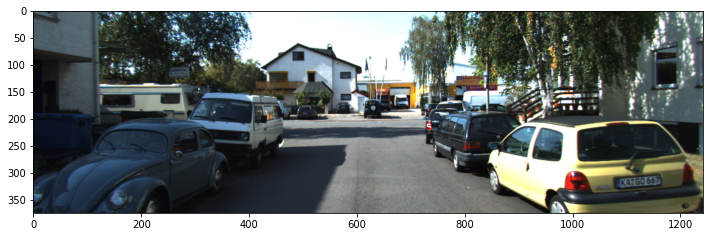

## test example 1
['image', 'image/file_name', 'objects']
-----     objects     -----
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.64, -1.63, -1.86], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.44257978, 0.5377357 , 0.5406117 , 0.57342464],
       [0.47164893, 0.5113457 , 0.5253723 , 0.5313538 ],
       [0.48534575, 0.48294923, 0.52316487, 0.50398064]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.6 , 1.76, 3.84],
       [1.39, 1.56, 3.45],
       [1.41, 1.66, 3.76]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 3.71,  1.05, 33.42],
       [ 2.77,  0.92, 51.6 ],
       [ 0.45,  0.82, 74.07]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.53, -1.58, -1.86], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=ar

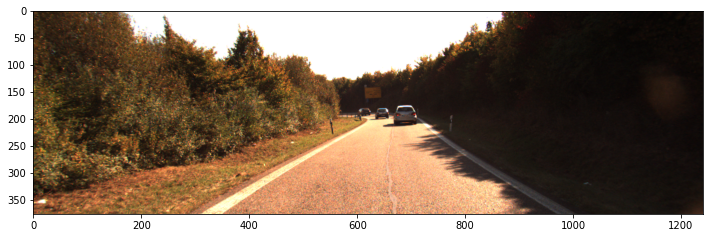

(<PIL.Image.Image image mode=RGB size=1241x376 at 0x7E85CC0A6C40>,
 {'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.64, -1.63, -1.86], dtype=float32)>,
  'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
  array([[0.44257978, 0.5377357 , 0.5406117 , 0.57342464],
         [0.47164893, 0.5113457 , 0.5253723 , 0.5313538 ],
         [0.48534575, 0.48294923, 0.52316487, 0.50398064]], dtype=float32)>,
  'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
  array([[1.6 , 1.76, 3.84],
         [1.39, 1.56, 3.45],
         [1.41, 1.66, 3.76]], dtype=float32)>,
  'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
  array([[ 3.71,  1.05, 33.42],
         [ 2.77,  0.92, 51.6 ],
         [ 0.45,  0.82, 74.07]], dtype=float32)>,
  'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>,
  'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.53, -1.58, -1.86], dtype=float32)>,
  'truncated': <tf.Tensor: shape=(3,), dtype=float

In [7]:
check_sample(train_sample, "train")
check_sample(valid_sample, "valid")
check_sample(test_sample, "test")

#### kitti 레이블 포맷 중 bbox
`[y_min, x_min, y_max, x_max]`으로 구성  

In [8]:
## 그림에 바운딩 박스 그리기
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    ## 바운딩 박스 좌표 구하기 
    width, height = input_image.size
    x_min = object_bbox[:, 3] * width
    x_max = object_bbox[:, 1] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    ## 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        ## _rect의 형태 (좌상단 꼭짓점 좌표, 우하단 꼭짓점 좌표)
        draw.rectangle(_rect, outline=(255,0,0), width=2) 
    
    return input_image

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.55,  1.85], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.48656   , 0.47563607, 0.56890666, 0.49858293],
       [0.45904   , 0.33416265, 0.50829333, 0.3629549 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.85,  2.63, 12.34],
       [ 1.46,  1.86,  4.01]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ -0.39,   1.89,  73.51],
       [-14.82,   2.44,  60.5 ]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.56,  1.61], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 0])>}


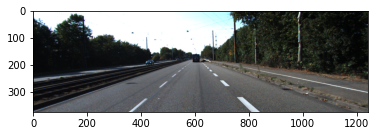

In [9]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

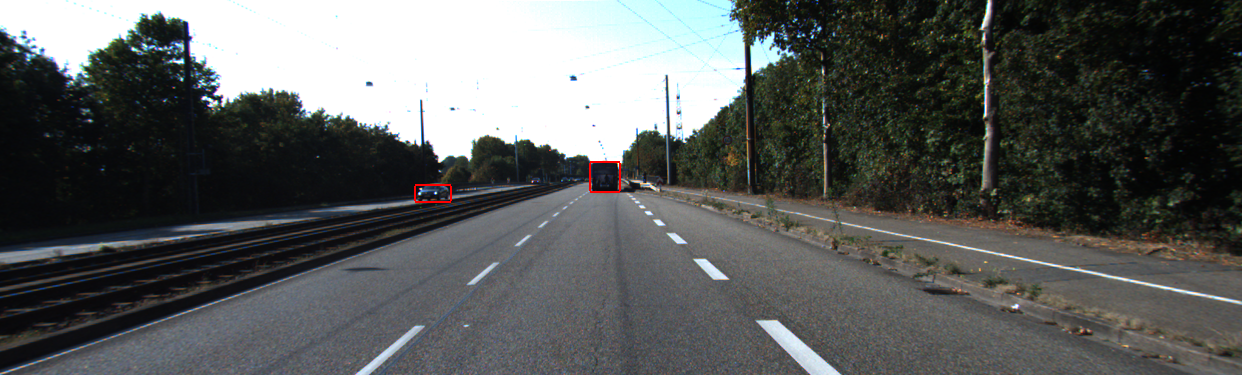

In [10]:
visualize_bbox(img, objects['bbox'].numpy())

### 데이터 가공 및 준비
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표게를 `[x_min, y_min, x_max, y_max]`에서 `[x_min, y_min, width, height]`로 수정

In [11]:
## x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

## 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

## 이미지 크기 조정 및 패딩 추가 
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    
    return image, image_shape, ratio

## 좌표게를 `[x_min, y_min, x_max, y_max]`에서 `[x_min, y_min, width, height]`로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [12]:
## 한번에 연결
def preprocess_data(sample):
    image = sample["image"]

    ## 1. x와 y좌표 위치 교체
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    ## 2. 무작위로 수평 뒤집기(Flip)
    image, bbox = random_flip_horizontal(image, bbox)

    ## 3. 이미지 크기 조정 및 패딩 추가
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    
    ## 4. 좌표게를 `[x_min, y_min, x_max, y_max]`에서 `[x_min, y_min, width, height]`로 수정
    bbox = convert_to_xywh(bbox)
    
    return image, bbox, class_id

#### 인코딩

In [13]:
class AnchorBox:
    '''
    객체 탐지 모델에서 사용되는 anchor를 생성하는 역할을 합니다. 
    여러 스케일과 비율로 anchor를 만들고 입력 이미지의 크기에 따라
    적절하게 배치해줍니다.
    '''
    def __init__(self):
        '''
        anchor의 aspect ratios, scales, stride, areas를 정의합니다. 
        '''
        ## anchor의 가로 세로 비율을 나타냅니다. 
        self.aspect_ratios = [0.5, 1.0, 2.0]
        ## anchor의 크기를 조정하는 비율을 정의합니다. 
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        ## anchor의 수
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        ## 이미지 피라미드에서 특성 맵의 해상도를 감소시킬 때 사용됩니다.  
        self._strides = [2 ** i for i in range(3, 8)]
        ## anchor의 기본 면적을 정의합니다. 
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        ## _compute_dims를 통해 각 면적, 비율, 스케일에 따른 모든 anchor 크기를 미리 계산합니다. 
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        '''
        주어진 aspect_ratios, scales, area에 따라 각 anchor의 크기를 계산합니다. 
        '''
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                ## aspect_ratios에 따라 게산
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    ## scale을 곱해 최종 크기 결정
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
            
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        '''
        특성 맵의 크기에 따라 anchor를 생성합니다. 
        '''
        ## 특성 맵의 가로와 세로 좌표를 생성합니다. 
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        
        ## 각 좌표를 중심으로 anchor의 중심점을 계산합니다. 
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        
        ## 미리 생성된 anchor의 크기를 불러옵니다.  
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        
        ## 중심점과 크기를 결합하여 최종적으로 anchor를 생성하고 1차원 배열로 반환합니다. 
        anchors = tf.concat([centers, dims], axis=-1)
        
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        '''
        주어진 이미지 크기에서 모든 anchor를 생성합니다. 
        피라미드 수준마다 다른 stride와 해상도를 사용해 anchor를 만듭니다. 
        '''
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [14]:
def convert_to_corners(boxes):
    '''
    [cx, cy, w, h] 형식의 bounding box를 중심 좌표를 기준으로 
    [xmin, ymin, xmax, ymax] 형식으로 변환합니다. 
    '''
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    ## 박스 형태 변환
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    
    ## 교차 영역 계산 
    ## 두 박스의 좌상단 좌표 중 큰 값
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2]) 
    ## 두 박스의 우하단 좌표 중 큰 값
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    ## 교차 영역
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    
    ## 면적 계산
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    
    ## 합집한 면적 계산
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    
    ## IoU 계산
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [15]:
class LabelEncoder:
    '''
    객체 탐지 모델에서 사용되는 anchor를 기반으로 라벨을 인코딩하는 역할을 합니다. 
    주어진 이미지와 Ground Truth(GT) 데이터를 바탕으로, anchor와 GT 박스를 매칭하고, 
    모델 학습에 필요한 포맷으로 변환합니다.
    '''
    def __init__(self):
        '''
        anchor와 박스 인코딩 시 사용될 variance 값 초기화
        '''
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        '''
        각 anchor와 GT 박스의 IoU를 계산하여 가장 높은 IoU 값을 기준으로 매칭시킵니다. 
        '''
        ## anchor와 GT 박스의 IoU를 계산
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        
        ## 높은 iou 추출
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        
        ## positive_mask는 match_iou 이상인 박스를 양성(positive)으로 표시
        positive_mask = tf.greater_equal(max_iou, match_iou)
        ## negative_mask는 ignore_iou 미만인 박스를 음성(negative)으로 표시
        negative_mask = tf.less(max_iou, ignore_iou)
        ## 위 두 조건을 만족하지 않으면 무시(ignore)으로 표시
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        '''
        
        '''
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

### `루브릭 1`  KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.

### 모델 준비 및 학습

#### 모델 준비

In [16]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [17]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [18]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

#### loss 설정

In [20]:
## loss 설정
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

#### mAP 구현

In [21]:
# import tensorflow as tf

# class MeanAveragePrecision(tf.keras.metrics.Metric):
#     def __init__(self, iou_threshold=0.5, name='mAP', **kwargs):
#         super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
#         self.iou_threshold = iou_threshold
#         self.ap_list = []
        
#     def update_state(self, y_true, y_pred, sample_weight=None):
#         batch_size = tf.shape(y_true)[0]
#         for batch_idx in range(batch_size):
#             gt_boxes = y_true[batch_idx]
#             pred_boxes = y_pred[batch_idx][..., :4]
#             pred_scores = y_pred[batch_idx][..., 4]

#             ap = self.compute_ap(pred_boxes, pred_scores, gt_boxes)
#             self.ap_list.append(ap)
        
#     def result(self):
#         return tf.reduce_mean(self.ap_list)
    
#     def reset_states(self):
#         self.ap_list = []
    
#     def iou(self, box1, box2):
#         x1, y1, x2, y2 = tf.split(box1, 4)
#         x1_gt, y1_gt, x2_gt, y2_gt = tf.split(box2, 4)

#         xi1 = tf.maximum(x1, x1_gt)
#         yi1 = tf.maximum(y1, y1_gt)
#         xi2 = tf.minimum(x2, x2_gt)
#         yi2 = tf.minimum(y2, y2_gt)

#         inter_area = tf.maximum(xi2 - xi1, 0) * tf.maximum(yi2 - yi1, 0)
#         box1_area = (x2 - x1) * (y2 - y1)
#         box2_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
#         union_area = box1_area + box2_area - inter_area

#         iou = inter_area / (union_area + tf.keras.backend.epsilon())
#         return iou
    
#     def compute_ap(self, pred_boxes, pred_scores, gt_boxes):
#         sorted_indices = tf.argsort(pred_scores, direction='DESCENDING')
#         pred_boxes = tf.gather(pred_boxes, sorted_indices)
        
#         tp = tf.zeros_like(pred_scores)
#         fp = tf.zeros_like(pred_scores)
        
#         matched = set()
        
#         for i in range(tf.shape(pred_boxes)[0]):
#             pred_box = pred_boxes[i]
#             best_iou = 0
#             best_gt_idx = -1
            
#             for j in range(tf.shape(gt_boxes)[0]):
#                 # Use `tf.py_function` to convert `j` tensor to int in graph mode
#                 j_index = tf.py_function(lambda x: int(x.numpy()), [j], tf.int64)
#                 j_index = int(j_index.numpy())  # Convert back to Python int
                
#                 if j_index not in matched:
#                     iou_val = self.iou(pred_box, gt_boxes[j])
#                     if iou_val > best_iou:
#                         best_iou = iou_val
#                         best_gt_idx = j_index

#             if best_iou >= self.iou_threshold:
#                 tp = tf.tensor_scatter_nd_update(tp, [[i]], [1.0])
#                 matched.add(best_gt_idx)
#             else:
#                 fp = tf.tensor_scatter_nd_update(fp, [[i]], [1.0])

#         tp_cumsum = tf.cumsum(tp)
#         fp_cumsum = tf.cumsum(fp)
        
#         precision = tp_cumsum / (tp_cumsum + fp_cumsum + tf.keras.backend.epsilon())
#         recall = tp_cumsum / (tf.shape(gt_boxes)[0] + tf.keras.backend.epsilon())
        
#         ap = 0.0
#         for t in tf.linspace(0.0, 1.0, 11):
#             p = tf.reduce_max(tf.where(recall >= t, precision, 0.0))
#             ap += p / 11
#         return ap

mAP 적용 코드 실패

#### 모델 학습

In [22]:
num_classes = 8
batch_size = 8

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 0s 0us/step


In [23]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(
    loss=loss_fn, 
    optimizer=optimizer, 
    metrics=[
#         tf.keras.metrics.MeanIoU(num_classes=num_classes), ## 라벨에 음수가 있어서 안된다..
#         MeanAveragePrecision(iou_threshold=0.5)
    ]
)

In [24]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [25]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/my_checkpoints_batch8/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    ), 
    CSVLogger('training_batch8.log')
]

epochs = 20

history_model = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/20
793/793 [==============================] - 1595s 2s/step - loss: 2.8551 - val_loss: 1.8868

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/my_checkpoints_batch8/weights_epoch_1
Epoch 2/20
793/793 [==============================] - 1535s 2s/step - loss: 1.2147 - val_loss: 1.3869

Epoch 00002: saving model to /aiffel/aiffel/object_detection/data/my_checkpoints_batch8/weights_epoch_2
Epoch 3/20
793/793 [==============================] - 1540s 2s/step - loss: 0.8470 - val_loss: 1.2326

Epoch 00003: saving model to /aiffel/aiffel/object_detection/data/my_checkpoints_batch8/weights_epoch_3
Epoch 4/20
793/793 [==============================] - 1545s 2s/step - loss: 0.6692 - val_loss: 1.0752

Epoch 00004: saving model to /aiffel/aiffel/object_detection/data/my_checkpoints_batch8/weights_epoch_4
Epoch 5/20
793/793 [==============================] - 1544s 2s/step - loss: 0.5596 - val_loss: 1.1036

Epoch 00005: saving model to /aiffel/aiffel/object_detection/data/my_

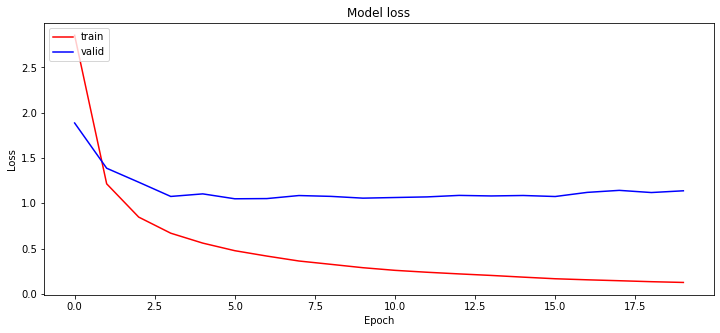

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
training_log = pd.read_csv("training_batch8.log")

plt.figure(figsize=(12,5))
plt.plot(training_log['loss'], 'r')
plt.plot(training_log['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')

weights_epoch_5부터 val_loss가 올라간다. 
train loss는 계속 떨어진다. 
weights_epoch_5, 즉, epoch6을 과적합으로 두자  

### `루브릭 2` RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.

### 모델 추론
batch_size가 2이고 epoch이 12인 모델의 가중치를 불러와 사용한다.   

In [58]:
checkpoint_model = RetinaNet(num_classes, resnet50_backbone)
latest_checkpoint = tf.train.latest_checkpoint((os.getenv('HOME') + '/aiffel/object_detection/data/my_checkpoints/'))
checkpoint_model.load_weights(latest_checkpoint)
# checkpoint_model.load_weights(os.getenv('HOME') + "/aiffel/object_detection/data/my_checkpoints_batch8/weights_epoch_5")

In [59]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [60]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = checkpoint_model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [61]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [62]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

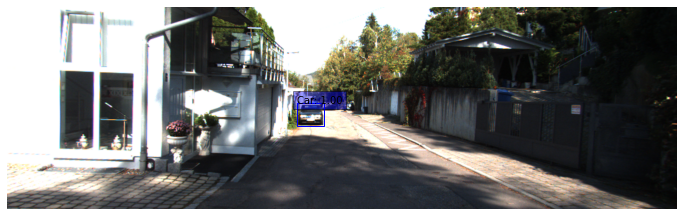

class names : Car            score : 1.0


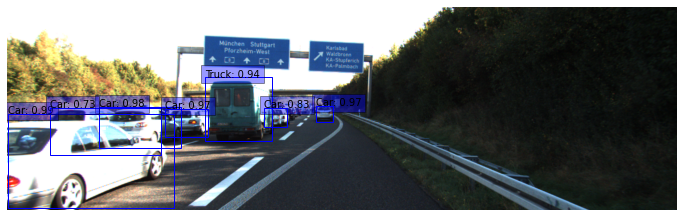

class names : Car            score : 0.9900000095367432
class names : Car            score : 0.9800000190734863
class names : Car            score : 0.9700000286102295
class names : Car            score : 0.9700000286102295
class names : Truck            score : 0.9399999976158142
class names : Car            score : 0.8299999833106995
class names : Car            score : 0.7300000190734863


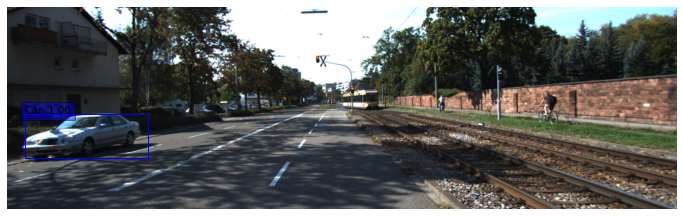

class names : Car            score : 1.0


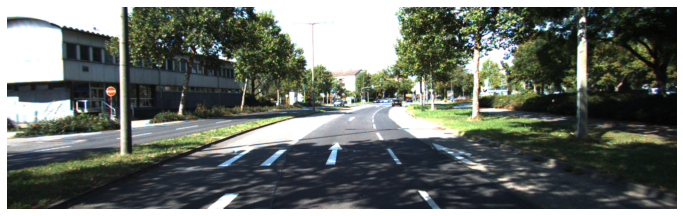

No Detection


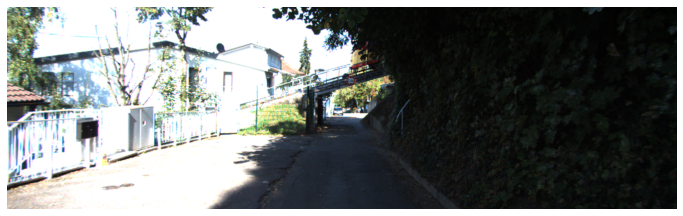

No Detection


In [73]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(5):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    if len(class_names) == 0:
        print("No Detection")
    else:
        for cls_n, cls_s in zip(class_names, detections.nmsed_scores[0][:num_detections]):
            print(f"class names : {cls_n}\
            score : {np.round(cls_s, 2)}")

batch8로 20까지 돌리고 val_loss가 최솟값일때의 가중치를 불러와 결과를 확인하니 batch2로 12의 결과가 더 좋게 나왔다.   
batch2로 12의 가중치만 저장하고 loss값들을 저장하지 못했다.. 그래서 그래프를 그려보지 못함..  

2번째 사진을 보면 가려져있는 자동차까지도 잘 탐지하는 것처럼 보인다.  
score도 90이 넘는 것들이 많고 심지어 반올림하여 100인 것들도 있다.  

### 자율주행 시스템 만들기

In [84]:
def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    gostop_img = Image.open(img_path)
    gostop_img = tf.cast(gostop_img, dtype=tf.float32)
    input_image, ratio = prepare_image(gostop_img)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]

    boxes = detections.nmsed_boxes[0][:num_detections]/ratio
    w, h = boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]
    
    ## 자율주행 결과 시각화
    visualize_detections(
        gostop_img,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections], 
        figsize=(12, 12)
    )
    
    # 정지조건에 맞으면 return "Stop"
    condition1 = "Pedestrian" in class_names
    condition2 = True in [w_ >= 300 or h_ >= 300 for w_, h_ in zip(w, h)]
    
    if condition1 or condition2:
        print("Stop")
        return "Stop"
    
    # 아닌 경우 return "Go"
    else:
        print("Go")
        return "Go"

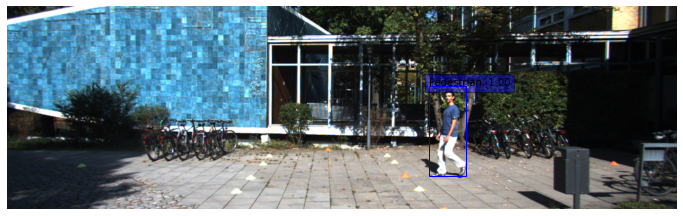

Stop


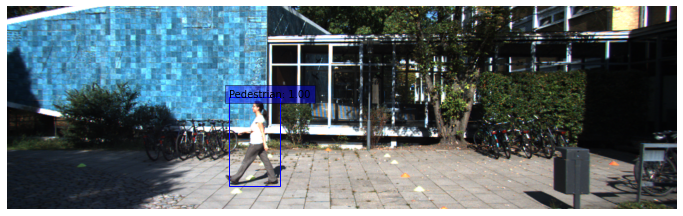

Stop


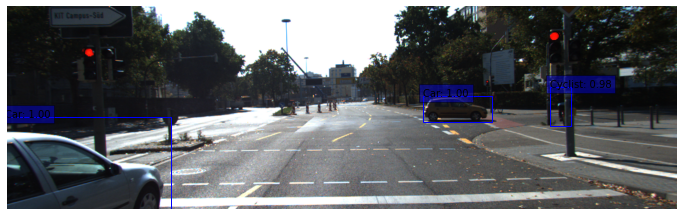

Stop


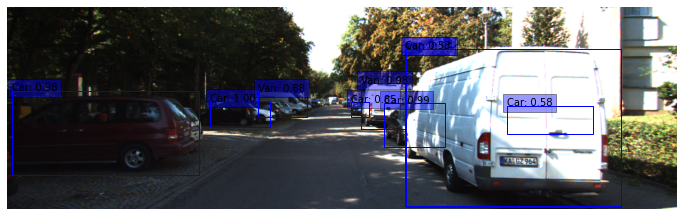

Stop


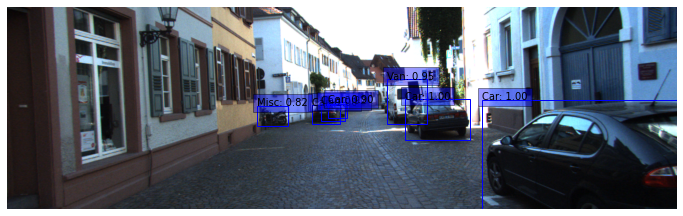

Stop


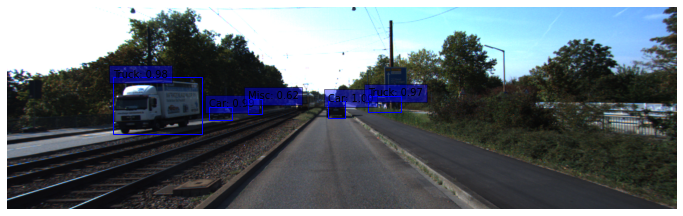

Go


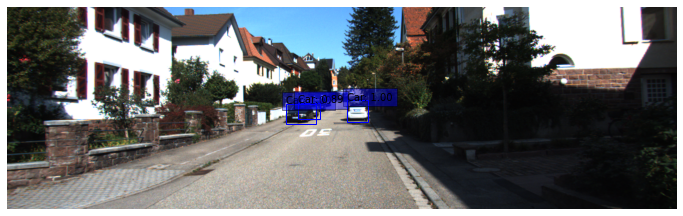

Go


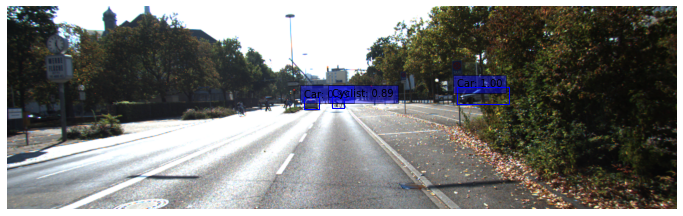

Go


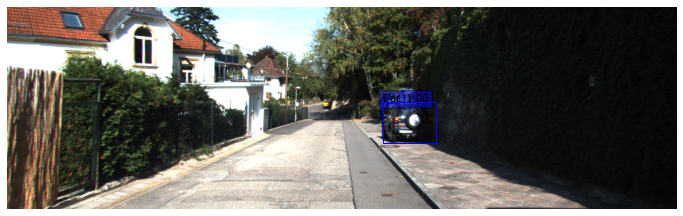

Go


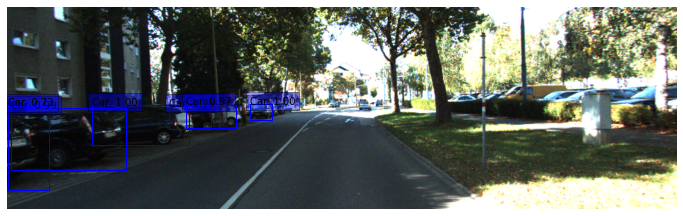

Go
100점입니다.


In [85]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

현재 Go&Stop 함수에서는 조건을 단순히 사람이 있는지와 차의 크기가 300이 넘는지를 통해 Go 와 Stop을 결정했다.  
실제로 사용한다면 Lane Detection을 통해 사람이 차선에 있지 않고 인도에 있는지를 확인해서 Go 혹은 Stop을 결정하면 더 정확할 것 같다.  
또한 Depth Estimation을 통해 앞 차량과의 거리를 추정하여 Go 혹은 Stop을 결정하면 더 정확할 것 같다.  

### `루브릭 3` 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.

## 회고 
자율 주행 task에는 Object Detection 뿐만 아니라 많은 task가 사용된다.  
Lane Detection, Depth Estimation 등과 같은 여러 task에 대해서도 알아보자.  

기존의 방식에 다른 무언가(예를 들면 metric)를 추가하는 것은 코드를 정확히 알지 못하면 어려운 것 같다.  